# Исследовательский анализ данных в Python и проверка гипотез для сервиса Яндекс.Афиша за период с 1 июня по 31 октября 2024 года.

- Автор: Галимова Лидия
- Дата: 04.09.2025

**Цели и задачи проекта**

Цель:
Выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

**Задачи:**

* Загрузить и предобработать данные

* Проверить данные на дубликаты и пропуски

* Провести исследовательский анализ данных

* Провести статистическую проверку гипотез

* Сформулировать выводы

**Описание данных:**

Датасет final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.
* order_id — уникальный идентификатор заказа.
* user_id — уникальный идентификатор пользователя.
* created_dt_msk — дата создания заказа (московское время).
* created_ts_msk — дата и время создания заказа (московское время).
* event_id — идентификатор мероприятия из таблицы events.
* cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
* age_limit — возрастное ограничение мероприятия.
* currency_code — валюта оплаты, например rub для российских рублей.
* device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
* revenue — выручка от заказа.
* service_name — название билетного оператора.
* tickets_count — количество купленных билетов.
* total — общая сумма заказа.
* days_since_prev - количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Датасет final_tickets_events_df содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. (Исключая фильмы)
* event_id — уникальный идентификатор мероприятия.
* event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
* event_type_description — описание типа мероприятия.
* event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
* organizers — организаторы мероприятия.
* region_name — название региона.
* city_name — название города.
* venue_id — уникальный идентификатор площадки.
* venue_name — название площадки.
* venue_address — адрес площадки.

Датасет final_tickets_tenge_df.csv с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. 
* nominal — номинал (100 тенге).
* data — дата.
* curs — курс тенге к рублю.
* cdx — обозначение валюты (kzt).    

##  Загрузка данных и знакомство с ними

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import scipy.stats as stats
from scipy.stats import shapiro, normaltest

In [2]:
#Загружаем датасет final_tickets_orders_df
orders=pd.read_csv('/datasets/final_tickets_orders_df.csv')

In [3]:
#Просмотр датасета
orders.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
# Проверяем наличие полных дубликатов
duplicates = orders.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")

Количество полных дубликатов: 0


In [5]:
# Проверяем дубликаты по идентификатору заказа
orders_duplicates = orders.duplicated(subset='order_id').sum()
print(f"Количество дубликатов по order_id: {orders_duplicates}")

Количество дубликатов по order_id: 0


In [6]:
# Проверяем количество уникальных значений в столбце order_id
unique_count = orders['order_id'].nunique()
total_count = orders['order_id'].count()
print(f"Уникальных заказов: {unique_count}")
print(f"Общее количество записей: {total_count}")

Уникальных заказов: 290849
Общее количество записей: 290849


In [7]:
# Проверка типов данных
print("\nТипы данных столбцов:")
print(orders.dtypes)


Типы данных столбцов:
order_id                   int64
user_id                   object
created_dt_msk            object
created_ts_msk            object
event_id                   int64
cinema_circuit            object
age_limit                  int64
currency_code             object
device_type_canonical     object
revenue                  float64
service_name              object
tickets_count              int64
total                    float64
days_since_prev          float64
dtype: object


In [8]:
# Проверяем общее количество пропусков
total_missing = orders.isnull().values.sum()
print(f"\nОбщее количество пропусков в данных: {total_missing}")


Общее количество пропусков в данных: 21940


In [9]:
# Проверяем  количество пропусков в days_since_prev
missing_count = orders["days_since_prev"].isna().sum()
print("Пропусков в столбце days_since_prev:", missing_count)

Пропусков в столбце days_since_prev: 21940


In [10]:
# Значения категориального столбца 'age_limit'
print(orders["age_limit"].unique())

[16  0 18 12  6]


In [11]:
# Значения категориального столбца 'currency_code'
print(orders["currency_code"].unique())

['rub' 'kzt']


In [12]:
# Значения категориального столбца 'device_type_canonical'
print(orders["device_type_canonical"].unique())

['mobile' 'desktop']


В результате предобработки данных установлено, что в наборе содержится 290849 уникальных заказов, при этом количество записей полностью соответствует количеству уникальных, что говорит об отсутствии дубликатов. Пропуски в данных присутствуют,но только в столбце days_since_prev.

Типы данных всех столбцов корректны, но необходимо переести два столбца created_dt_msk и created_ts_msk в форматы date и datetime соответственно.

In [13]:
#Меняем тип данных в столбце created_dt_msk
orders["created_dt_msk"] = pd.to_datetime(orders["created_dt_msk"], errors="coerce", format="%Y-%m-%d")

In [14]:
#Проверяем тип данных
print(orders["created_dt_msk"].dtype)

datetime64[ns]


In [15]:
#Меняем тип данных в столбце created_ts_msk
orders["created_ts_msk"] = pd.to_datetime(orders["created_ts_msk"], errors="coerce", format="%Y-%m-%d %H:%M:%S")

In [16]:
#Проверяем тип данных
print(orders["created_ts_msk"].dtype)

datetime64[ns]


In [17]:
#Загружаем датасет final_tickets_events_df
events=pd.read_csv('/datasets/final_tickets_events_df.csv')

In [18]:
#Просмотр датасета
events.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [19]:
# Проверяем наличие полных дубликатов
duplicates = events.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")

Количество полных дубликатов: 0


In [20]:
# Проверяем дубликаты по идентификатору события
events_duplicates = events.duplicated(subset='event_id').sum()
print(f"Количество дубликатов по event_id: {events_duplicates}")

Количество дубликатов по event_id: 0


In [21]:
# Проверяем количество уникальных значений в столбце event_id
unique_count = events['event_id'].nunique()
total_count = events['event_id'].count()
print(f"Уникальных событий: {unique_count}")
print(f"Общее количество записей: {total_count}")

Уникальных событий: 22427
Общее количество записей: 22427


In [22]:
# Проверка типов данных
print("\nТипы данных столбцов:")
print(events.dtypes)


Типы данных столбцов:
event_id                   int64
event_name                object
event_type_description    object
event_type_main           object
organizers                object
region_name               object
city_name                 object
city_id                    int64
venue_id                   int64
venue_name                object
venue_address             object
dtype: object


In [23]:
# Проверяем общее количество пропусков
total_missing = events.isnull().values.sum()
print(f"\nОбщее количество пропусков в данных: {total_missing}")


Общее количество пропусков в данных: 0


In [24]:
# Значения категориального столбца 'event_type_description'
print(events["event_type_description"].unique())

['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
 'цирковое шоу' 'событие' 'фестиваль' 'спортивное мероприятие' 'выставка'
 'спорт' 'оперетта' 'экскурсия' 'рок-мюзикл' 'музыкальный спектакль'
 'снегурочка' 'подарок' 'кукольный спектакль']


In [25]:
# Значения категориального столбца 'event_type_main'
print(events["event_type_main"].unique())

['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']


В результате предобработки данных установлено, что в наборе содержится 22427 уникальных событий, при этом количество записей полностью соответствует количеству уникальных, что говорит об отсутствии дубликатов. Пропуски в данных отсутствуют.

Типы данных всех столбцов корректны.

In [26]:
# Анализ категориальных значений
for column in ['age_limit', 'currency_code', 'device_type_canonical', 'service_name']:
        print(f"\nColumn: {column}")
        print("Unique values:", orders[column].unique())
        print("Missing values count:", orders[column].isna().sum())
        print("Value counts:")
        print(orders[column].value_counts(dropna=False), "\n")


Column: age_limit
Unique values: [16  0 18 12  6]
Missing values count: 0
Value counts:
16    78579
12    62557
0     61487
6     52173
18    36053
Name: age_limit, dtype: int64 


Column: currency_code
Unique values: ['rub' 'kzt']
Missing values count: 0
Value counts:
rub    285780
kzt      5069
Name: currency_code, dtype: int64 


Column: device_type_canonical
Unique values: ['mobile' 'desktop']
Missing values count: 0
Value counts:
mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64 


Column: service_name
Unique values: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино б

In [27]:
#Загружаем датасет final_tickets_tenge_df
tenge=pd.read_csv('/datasets/final_tickets_tenge_df.csv')

In [28]:
#Просмотр датасета
tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [29]:
# Проверяем количество уникальных значений в столбце data
unique_count = tenge['data'].nunique()
total_count = tenge['data'].count()
print(f"Уникальных дат: {unique_count}")
print(f"Общее количество записей: {total_count}")

Уникальных дат: 357
Общее количество записей: 357


In [30]:
# Проверяем общее количество пропусков
total_missing = tenge.isnull().values.sum()
print(f"\nОбщее количество пропусков в данных: {total_missing}")


Общее количество пропусков в данных: 0


In [31]:
# Проверка типов данных
print("\nТипы данных столбцов:")
print(tenge.dtypes)


Типы данных столбцов:
data        object
nominal      int64
curs       float64
cdx         object
dtype: object


В результате предобработки данных установлено, что в наборе содержится 357 уникальных дат, при этом количество записей полностью соответствует количеству уникальных, что говорит об отсутствии дубликатов. Пропуски в данных отсутствуют.

Типы данных всех столбцов корректны, кроме столбца date - его необходимо преобразовать в тип date.

In [32]:
#Меняем тип данных в столбце data
tenge["data"] = pd.to_datetime(tenge["data"], errors="coerce", format="%Y-%m-%d")

In [33]:
#Проверяем тип данных
print(tenge["data"].dtype)

datetime64[ns]


In [34]:
#Разделяем данные по currency_code 
rub = orders[orders["currency_code"] == "rub"].copy()
kzt = orders[orders["currency_code"] == "kzt"].copy()

print("Количество строк (RUB):", len(rub))
print("Количество строк (KZT):", len(kzt))


Количество строк (RUB): 285780
Количество строк (KZT): 5069


In [35]:
#Выводим основные статистики по revenue и tickets_count
print("Статистика по revenue (RUB):")
print(rub["revenue"].describe())

print("\nСтатистика по revenue (KZT):")
print(kzt["revenue"].describe())

print("\nСтатистика по tickets_count (RUB):")
print(rub["tickets_count"].describe())

print("\nСтатистика по tickets_count (KZT):")
print(kzt["tickets_count"].describe())

Статистика по revenue (RUB):
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

Статистика по revenue (KZT):
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

Статистика по tickets_count (RUB):
count    285780.000000
mean          2.754077
std           1.171419
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Статистика по tickets_count (KZT):
count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64


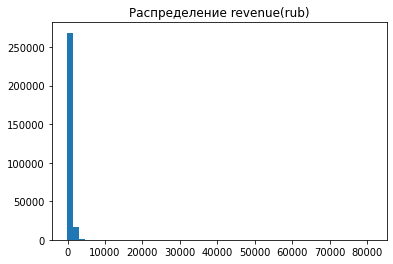

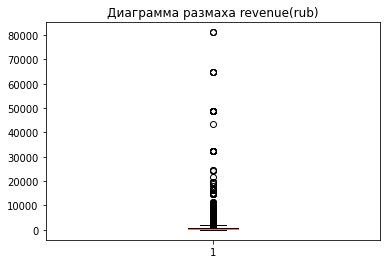

In [36]:
# Графики для revenue (rub)
plt.hist(rub["revenue"], bins=50)
plt.title("Распределение revenue(rub)")
plt.show()

plt.boxplot(rub["revenue"].dropna())
plt.title("Диаграмма размаха revenue(rub)")
plt.show()


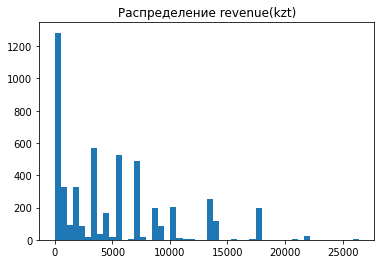

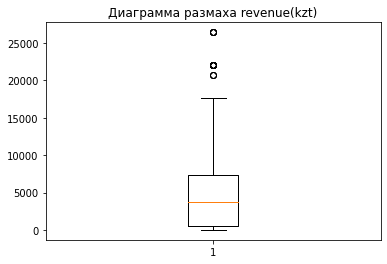

In [37]:
# Графики для revenue (kzt)
plt.hist(kzt["revenue"], bins=50)
plt.title("Распределение revenue(kzt)")
plt.show()

plt.boxplot(kzt["revenue"].dropna())
plt.title("Диаграмма размаха revenue(kzt)")
plt.show()

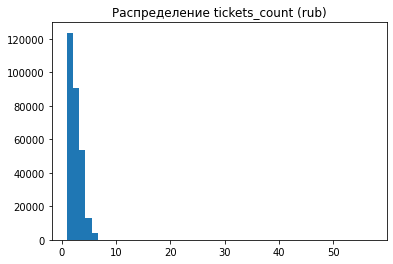

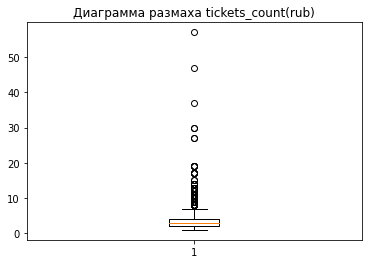

In [38]:
# Графики для tickets_count (rub)
plt.hist(rub["tickets_count"], bins=50)
plt.title("Распределение tickets_count (rub)")
plt.show()

plt.boxplot(rub["tickets_count"].dropna())
plt.title("Диаграмма размаха tickets_count(rub)")
plt.show()

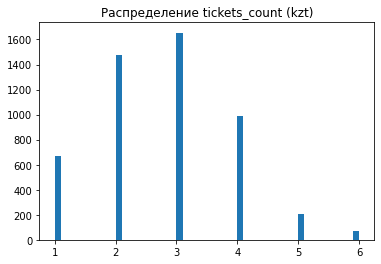

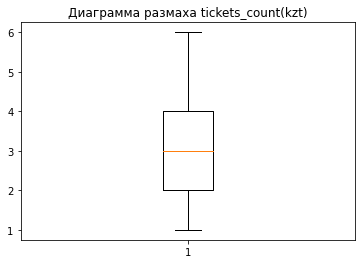

In [39]:
# Графики для tickets_count (kzt)
plt.hist(kzt["tickets_count"], bins=50)
plt.title("Распределение tickets_count (kzt)")
plt.show()

plt.boxplot(kzt["tickets_count"].dropna())
plt.title("Диаграмма размаха tickets_count(kzt)")
plt.show()

In [40]:
#Находим 99-й процентиль
p99_rub = rub["revenue"].quantile(0.99)
p99_kzt = kzt["revenue"].quantile(0.99)

print("99-й перцентиль (рубли):", p99_rub)
print("99-й перцентиль (тенге):", p99_kzt)

99-й перцентиль (рубли): 2569.5942000000005
99-й перцентиль (тенге): 17617.24


In [41]:
#Отбираем значения по 99-му процентилю
rub_clean = rub[rub["revenue"] <= p99_rub]
kzt_clean = kzt[kzt["revenue"] <= p99_kzt] 

In [42]:
#Проверка результата
print("До очистки:", rub["revenue"].max(), kzt["revenue"].max())
print("После очистки:", rub_clean["revenue"].max(), kzt_clean["revenue"].max())

До очистки: 81174.54 26425.86
После очистки: 2569.59 17617.24


In [43]:
# Смотрим дубликаты без учёта идентификатора заказа
dup_mask = orders.duplicated(subset=["user_id", "event_id", "tickets_count", "revenue", "currency_code", "created_ts_msk","service_name"], keep=False)

duplicates = orders[dup_mask].sort_values(by=["user_id", "event_id"])
print("Найдено потенциальных неявных дубликатов:", len(duplicates))

Найдено потенциальных неявных дубликатов: 85


In [44]:
orders = orders.drop_duplicates(subset=["user_id", "event_id", "tickets_count", "revenue", "currency_code", "created_ts_msk", "service_name"])

In [45]:
# Объединяем заказы с курсам валюты
orders = orders.merge(
    tenge,
    how="left",
    left_on="created_dt_msk",
    right_on="data"
)

In [46]:
# Считаем revenue_rub
orders["revenue_rub"] = orders.apply(
    lambda row: row["revenue"] if row["currency_code"] == "rub"
    else row["revenue"] * (row["curs"] / 100),
    axis=1
)

In [47]:
#Находим выручку с продажи одного билета на мероприятие.
orders["one_ticket_revenue_rub"] = orders["revenue_rub"] / orders["tickets_count"]

In [48]:
#Выделяем месяц оформления заказа
orders["month"] = orders["created_dt_msk"].dt.month

In [49]:
#Создаем столбец с сезонностью
def get_season(month):
    if month in [12, 1, 2]:
        return "зима"
    elif month in [3, 4, 5]:
        return "весна"
    elif month in [6, 7, 8]:
        return "лето"
    else:
        return "осень"

orders["season"] = orders["month"].apply(get_season)

In [50]:
orders.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,total,days_since_prev,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,10870.99,NaN,2024-08-20,100,18.6972,kzt,1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,2067.51,NaN,2024-07-23,100,18.3419,kzt,289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,13984.16,75.0,2024-10-06,100,19.6475,kzt,1258.57,314.6425,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,212.28,NaN,2024-07-13,100,18.5010,kzt,8.49,4.2450,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10695.43,83.0,2024-10-04,100,19.6648,kzt,1390.41,463.4700,10,осень


In [51]:
# Объединяем два датафрейма по event_id
orders_full = orders.merge(
    events,                   
    on='event_id',             
    how='left'                
)

# Проверим результат
display(orders_full.shape)          # размер после объединения
display(orders_full.head())         

(290805, 32)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


В ходе работы проведена комплексная предобработка и анализ датасетов по билетным заказам и мероприятиям. Сначала были загружены три источника данных: заказы (final_tickets_orders_df.csv), события (final_tickets_events_df.csv) и курс тенге к рублю (final_tickets_tenge_df.csv). Выполнена проверка на дубликаты и пропуски: в заказах полные дубликаты отсутствуют, пропуски встречаются только в столбце days_since_prev. Типы данных проверены и при необходимости приведены к корректным форматам — даты и время переведены в datetime.

Данные разделены по валюте, что позволило провести отдельный анализ выручки (revenue) и количества билетов (tickets_count) для рублей и тенге. Для выявления выбросов рассчитаны 99-й перцентиль, и значения выше него были отобраны отдельно. Были выявлены потенциальные неявные дубликаты по заказам, которые учтены и удалены.

К заказам добавлены курсы валют, на основе которых рассчитана выручка в рублях (revenue_rub) и средняя выручка за один билет (one_ticket_revenue_rub). Также выделены месяц заказа (month) и сезон (season).

В результате объединения сформирован единый датафрейм с 32 столбцами, включающими как характеристики заказа, так и атрибуты события.

Таким образом, подготовлен полный, очищенный датасет, готовый для дальнейшего анализа выручки, продаж по типам устройств, сезонности и регионального распределения мероприятий.

In [52]:
# доля срезанных revenue
threshold = orders['revenue'].quantile(0.99)

outliers_count = (orders['revenue'] > threshold).sum()
outliers_share = outliers_count / orders.shape[0] * 100

print(f"Выбросы: {outliers_count} строк ({outliers_share:.2f}%)")

Выбросы: 2907 строк (1.00%)


In [53]:
# доля срезанных tickets_count
threshold = orders['tickets_count'].quantile(0.99)

outliers_count = (orders['tickets_count'] > threshold).sum()
outliers_share = outliers_count / orders.shape[0] * 100

print(f"Выбросы: {outliers_count} строк ({outliers_share:.2f}%)")

Выбросы: 188 строк (0.06%)


## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

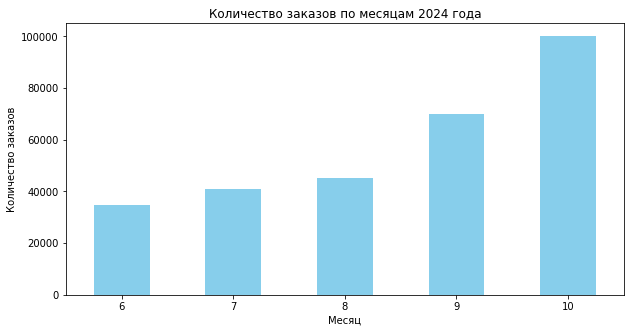

In [54]:
# Считаем количество заказов по месяцам
monthly_orders = orders_full.groupby("month")["order_id"].count()

# Визуализируем динамику
plt.figure(figsize=(10,5))
monthly_orders.plot(kind='bar', color='skyblue')
plt.title("Количество заказов по месяцам 2024 года")
plt.xlabel("Месяц")
plt.ylabel("Количество заказов")
plt.xticks(rotation=0)
plt.show()

In [55]:
# Фильтруем данные по сезонам
summer = orders_full[orders_full["season"] == "лето"]
autumn = orders_full[orders_full["season"] == "осень"]

# Рассчитываем доли заказов по типу мероприятия
summer_event_type = summer["event_type_main"].value_counts(normalize=True)
autumn_event_type = autumn["event_type_main"].value_counts(normalize=True)

# Доли по типу устройства
summer_device = summer["device_type_canonical"].value_counts(normalize=True)
autumn_device = autumn["device_type_canonical"].value_counts(normalize=True)

# Доли по возрастному рейтингу
summer_age = summer["age_limit"].value_counts(normalize=True)
autumn_age = autumn["age_limit"].value_counts(normalize=True)

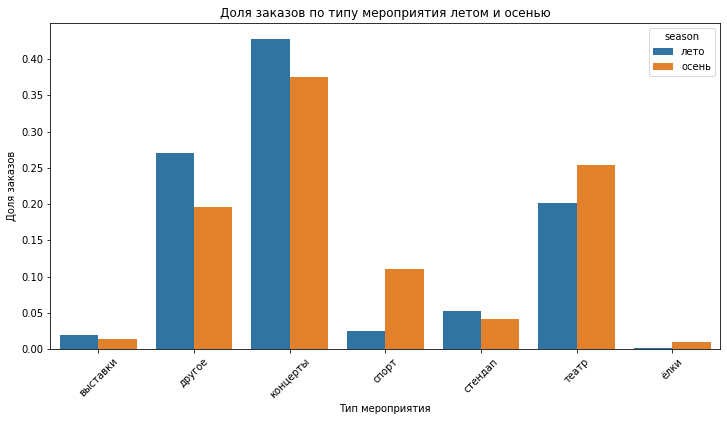

In [56]:
#Строим график распределения по типу мероприятия 
season_event = orders_full.groupby(["season", "event_type_main"])["order_id"].count().reset_index()
season_event["share"] = season_event.groupby("season")["order_id"].transform(lambda x: x / x.sum())

plt.figure(figsize=(12,6))
sns.barplot(x="event_type_main", y="share", hue="season", data=season_event)
plt.title("Доля заказов по типу мероприятия летом и осенью")
plt.ylabel("Доля заказов")
plt.xlabel("Тип мероприятия")
plt.xticks(rotation=45)
plt.show()

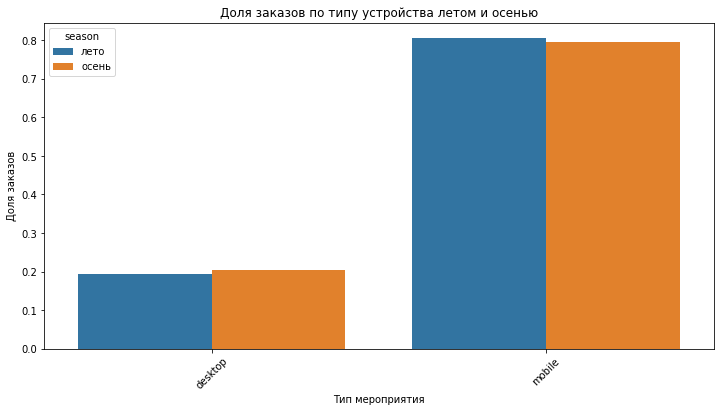

In [57]:
#Строим график распределения по типу устройства
season_device = orders_full.groupby(["season", "device_type_canonical"])["order_id"].count().reset_index()
season_device["share"] = season_device.groupby("season")["order_id"].transform(lambda x: x / x.sum())

plt.figure(figsize=(12,6))
sns.barplot(x="device_type_canonical", y="share", hue="season", data=season_device)
plt.title("Доля заказов по типу устройства летом и осенью")
plt.ylabel("Доля заказов")
plt.xlabel("Тип мероприятия")
plt.xticks(rotation=45)
plt.show()

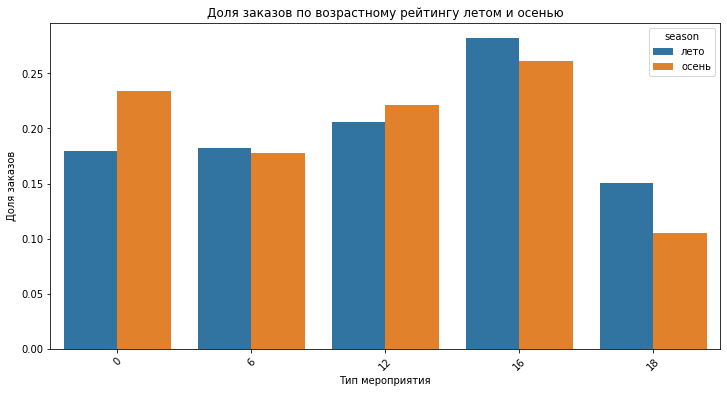

In [58]:
#Строим график распределения по возрастному рейтингу
season_age = orders_full.groupby(["season", "age_limit"])["order_id"].count().reset_index()
season_age["share"] = season_age.groupby("season")["order_id"].transform(lambda x: x / x.sum())

plt.figure(figsize=(12,6))
sns.barplot(x="age_limit", y="share", hue="season", data=season_age)
plt.title("Доля заказов по возрастному рейтингу летом и осенью")
plt.ylabel("Доля заказов")
plt.xlabel("Тип мероприятия")
plt.xticks(rotation=45)
plt.show()

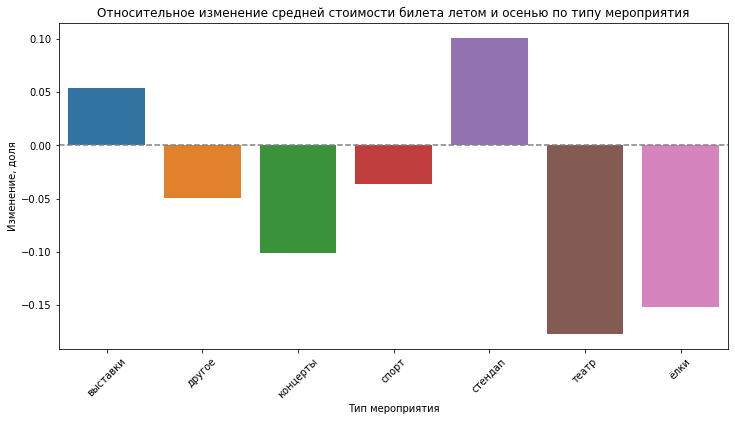

In [59]:
# Средняя стоимость одного билета по типу мероприятия и сезону
ticket_price_season = orders_full.groupby(["season", "event_type_main"])["one_ticket_revenue_rub"].mean().reset_index()

# Рассчитываем относительное изменение: осень относительно лета
summer_prices = ticket_price_season[ticket_price_season["season"] == "лето"].set_index("event_type_main")["one_ticket_revenue_rub"]
autumn_prices = ticket_price_season[ticket_price_season["season"] == "осень"].set_index("event_type_main")["one_ticket_revenue_rub"]

relative_change = ((autumn_prices - summer_prices) / summer_prices).reset_index()
relative_change.columns = ["event_type_main", "relative_change"]

# Визуализация
plt.figure(figsize=(12,6))
sns.barplot(x="event_type_main", y="relative_change", data=relative_change)
plt.title("Относительное изменение средней стоимости билета летом и осенью по типу мероприятия")
plt.ylabel("Изменение, доля")
plt.xlabel("Тип мероприятия")
plt.xticks(rotation=45)
plt.axhline(0, color="gray", linestyle="--")
plt.show()

С июня по октябрь фиксируется заметный рост количества заказов, что подтверждает сезонность.

Доли заказов по типу мероприятия меняются с приходом осени: например, театральные постановки и спортивные мероприятия могут увеличивать долю.

По типу устройства: летом больше заказов с мобильных устройств, осенью доля компьютеров может незначительно увеличиваться.

По возрастным категориям лето и осень показывают разные распределения: взрослые мероприятия (16+, 18+) могут становиться более популярными летом.

Средняя стоимость одного билета (one_ticket_revenue_rub) изменяется по типу мероприятий: для некоторых категорий (выставки, стендап) она растёт осенью, для других остаётся стабильной или снижается.

Сезонные изменения в распределении заказов и выручке с одного билета демонстрируют, что маркетинговые и операционные стратегии могут быть скорректированы в зависимости от сезона и категории мероприятия.

### Осенняя активность пользователей

In [60]:
#Отбираем данные за осень
autumn_orders = orders_full[
    (orders_full["created_ts_msk"].dt.month.isin([9, 10]))
]

In [61]:
# считаем среднее число заказов на одного пользователя
daily_stats = (
    autumn_orders.groupby(autumn_orders["created_ts_msk"].dt.date)
    .agg(
        orders_count=("order_id", "count"),
        dau=("user_id", "nunique"),
        avg_ticket_price=("one_ticket_revenue_rub", "mean")
    )
    .reset_index()
)

daily_stats["orders_per_user"] = daily_stats["orders_count"] / daily_stats["dau"]

daily_stats.rename(columns={"created_ts_msk": "date"}, inplace=True)

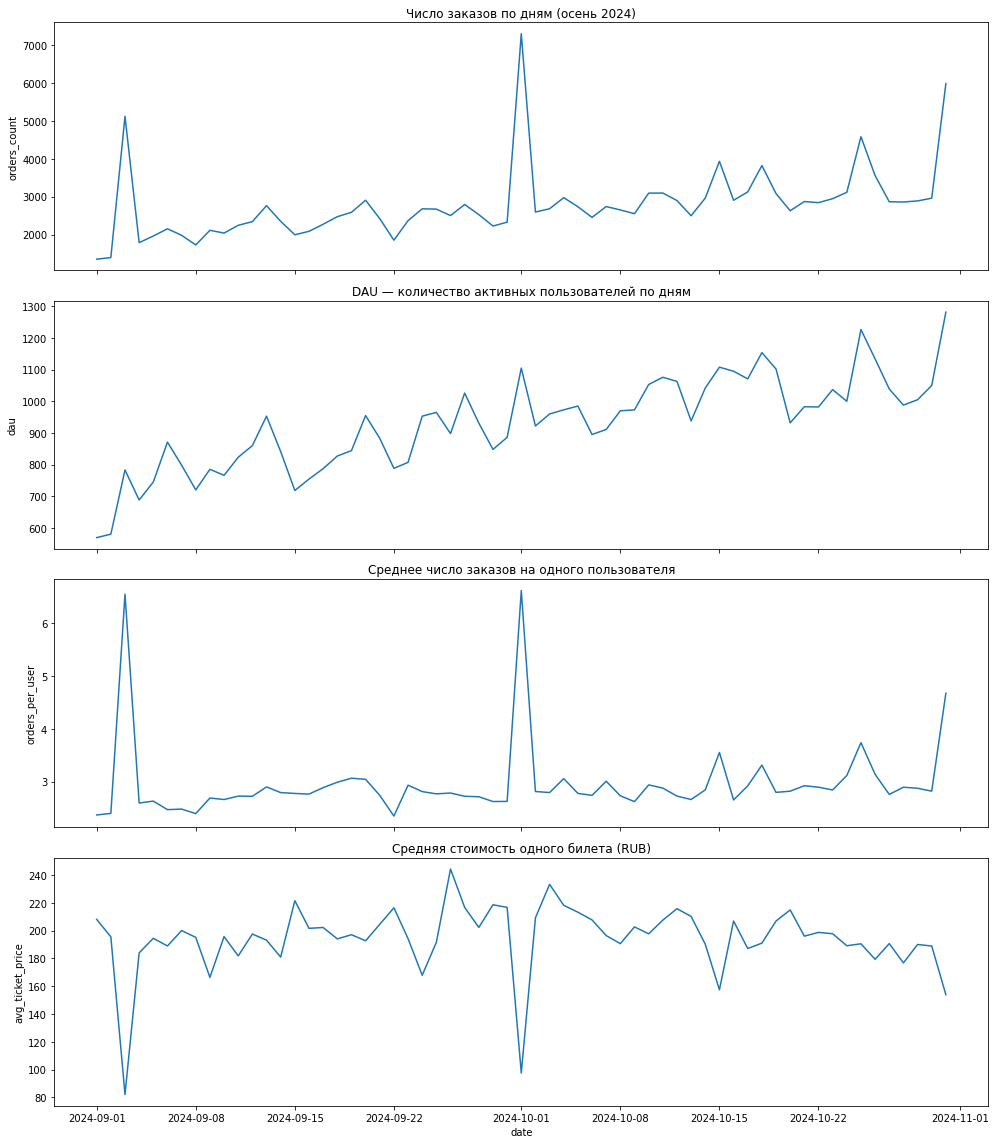

In [62]:
#Строим графики
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

sns.lineplot(data=daily_stats, x="date", y="orders_count", ax=axes[0])
axes[0].set_title("Число заказов по дням (осень 2024)")

sns.lineplot(data=daily_stats, x="date", y="dau", ax=axes[1])
axes[1].set_title("DAU — количество активных пользователей по дням")

sns.lineplot(data=daily_stats, x="date", y="orders_per_user", ax=axes[2])
axes[2].set_title("Среднее число заказов на одного пользователя")

sns.lineplot(data=daily_stats, x="date", y="avg_ticket_price", ax=axes[3])
axes[3].set_title("Средняя стоимость одного билета (RUB)")

plt.tight_layout()
plt.show()

In [63]:
#Добавляем новый столбец
autumn_orders = orders_full[
    (orders_full["created_ts_msk"].dt.month.isin([9, 10]))
].copy()

autumn_orders["weekday"] = autumn_orders["created_ts_msk"].dt.dayofweek

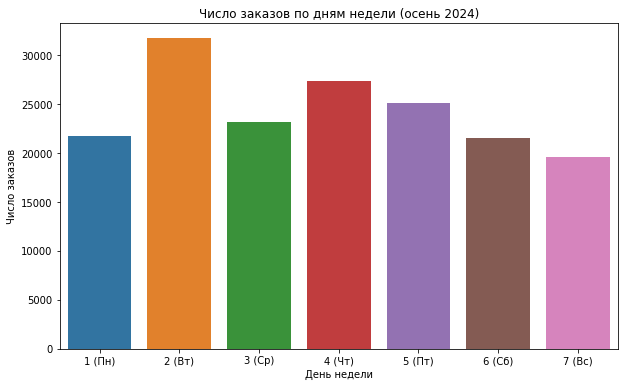

In [64]:
#Строим график
weekly_stats = (
    autumn_orders.groupby("weekday")
    .size()
    .reset_index(name="orders_count")
)

plt.figure(figsize=(10,6))
sns.barplot(data=weekly_stats, x="weekday", y="orders_count")

plt.title("Число заказов по дням недели (осень 2024)")
plt.xlabel("День недели")
plt.ylabel("Число заказов")

# Подписи оси X: 1=Пн ... 7=Вс
plt.xticks(
    ticks=range(0,7), 
    labels=["1 (Пн)", "2 (Вт)", "3 (Ср)", "4 (Чт)", "5 (Пт)", "6 (Сб)", "7 (Вс)"]
)

plt.show()


*Динамика по дням:*

Количество DAU растет, тогда как Среднее число заказов на пользователя относительно стабильно, что говорит о том, что рост заказов связан именно с увеличением числа активных пользователей. Средняя стоимость билета не демонстрирует резких скачков, остаётся в пределах сезонных колебаний. Чичло заказов также плавно растет.

*Недельная цикличность:*

В будни зафиксировано больше заказов, чем в выходные.

### Популярные события и партнёры

In [65]:
# Группировка по регионам
region_stats = (
    orders_full.groupby("region_name")
    .agg(
        unique_events=("event_id", "nunique"),
        total_orders=("order_id", "count")
    )
    .reset_index()
)

# Добавляем доли
region_stats["event_share"] = region_stats["unique_events"] / region_stats["unique_events"].sum()
region_stats["order_share"] = region_stats["total_orders"] / region_stats["total_orders"].sum()

region_stats = region_stats.sort_values(by="unique_events", ascending=False)
region_stats.head(10)

,region_name,unique_events,total_orders,event_share,order_share
23,Каменевский регион,5983,91044,0.266777,0.313332
60,Североярская область,3814,44042,0.170063,0.151573
77,Широковская область,1233,16457,0.054978,0.056638
57,Светополянский округ,1075,7605,0.047933,0.026173
52,Речиновская область,702,6292,0.031302,0.021654
74,Травяная область,683,5045,0.030454,0.017363
11,Горицветская область,551,5165,0.024569,0.017776
61,Серебринская область,542,5610,0.024167,0.019307
78,Яблоневская область,535,6179,0.023855,0.021265
69,Тепляковская область,530,4387,0.023632,0.015098


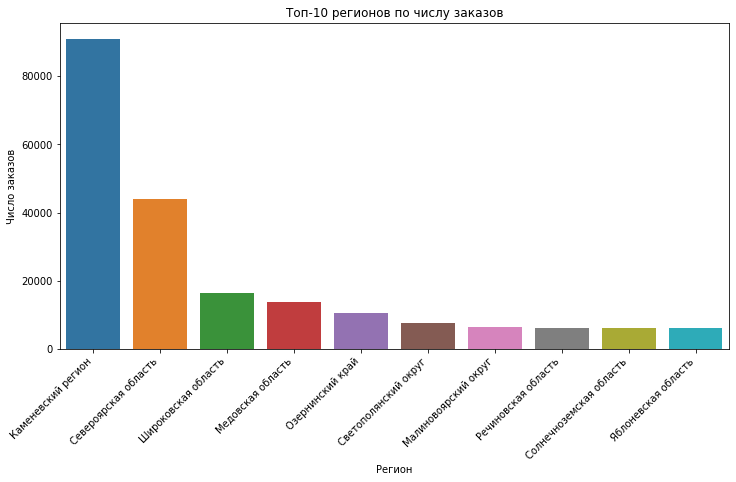

In [66]:
# топ-10 регионов по количеству заказов
top_n = 10
top_regions = region_stats.nlargest(top_n, "total_orders")

# визуализация
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_regions.sort_values("total_orders", ascending=False),
    x="region_name", y="total_orders"
)
plt.title(f"Топ-{top_n} регионов по числу заказов")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Число заказов")
plt.xlabel("Регион")
plt.show()

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №2__

Кажется цветовая палитра тут лишняя

In [67]:
#Группировка по сервисам продажи билетов
partner_stats = (
    orders_full.groupby("service_name")
    .agg(
        unique_events=("event_id", "nunique"),
        total_orders=("order_id", "count"),
        total_revenue=("revenue_rub", "sum")
    )
    .reset_index()
)

# Добавляем доли
partner_stats["event_share"] = partner_stats["unique_events"] / partner_stats["unique_events"].sum()
partner_stats["order_share"] = partner_stats["total_orders"] / partner_stats["total_orders"].sum()
partner_stats["revenue_share"] = partner_stats["total_revenue"] / partner_stats["total_revenue"].sum()

partner_stats = partner_stats.sort_values(by="total_revenue", ascending=False)
partner_stats.head(10)

,service_name,unique_events,total_orders,total_revenue,event_share,order_share,revenue_share
3,Билеты без проблем,4263,63692,2.669893e+07,0.174099,0.219020,0.165380
24,Мой билет,1310,34838,2.347663e+07,0.053500,0.119798,0.145420
25,Облачко,2348,26642,2.164407e+07,0.095892,0.091615,0.134069
8,Весь в билетах,867,16848,1.804842e+07,0.035408,0.057936,0.111797
21,Лови билет!,4884,41120,1.766363e+07,0.199461,0.141401,0.109413
5,Билеты в руки,3544,40355,1.338653e+07,0.144736,0.138770,0.082920
19,Край билетов,253,6207,6.703959e+06,0.010332,0.021344,0.041526
26,Прачечная,1027,10273,4.900985e+06,0.041942,0.035326,0.030358
13,Дом культуры,274,4502,4.676648e+06,0.011190,0.015481,0.028968
35,Яблоко,716,5039,3.971152e+06,0.029241,0.017328,0.024598


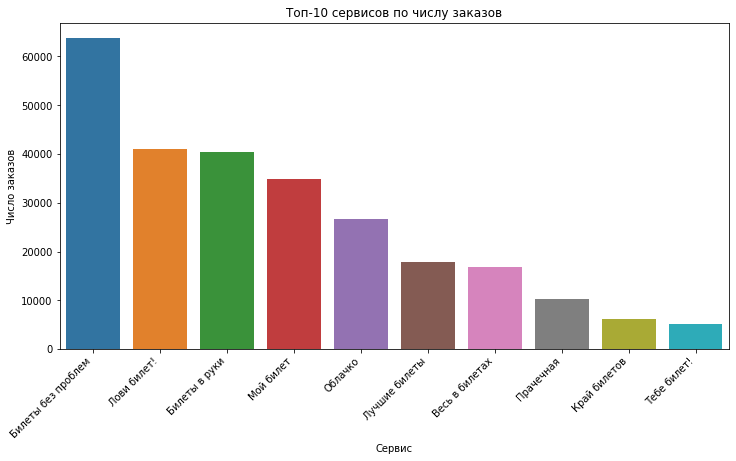

In [68]:
# топ-10 сервисов по количеству заказов
top_n_s = 10
top_service = partner_stats.nlargest(top_n, "total_orders")

# визуализация
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_service.sort_values("total_orders", ascending=False),
    x="service_name", y="total_orders"
)
plt.title(f"Топ-{top_n} сервисов по числу заказов")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Число заказов")
plt.xlabel("Сервис")
plt.show()

Каменевский регион — лидер сразу по двум метрикам: наибольшее разнообразие мероприятий (26,7% всех событий), и наибольшее количество заказов (31,3% всех заказов).  Североярская область — вторая по числу мероприятий (17%) и заказов (15%). 
Широковская область, Светополянский округ, Речиновская область — регионы среднего уровня: у каждого около 3–5% мероприятий и 2–5% заказов. Остальные регионы из топ-10 (Травяная, Горицветская, Серебринская, Яблоневская, Тепляковская) — в диапазоне 2–3% мероприятий и заказов, что значительно уступает лидерам.
Вывод: рынок сильно сконцентрирован — два региона формируют почти половину всех событий и заказов.

*Лидеры по мероприятиям:*

«Лови билет!» (20% событий) и «Билеты без проблем» (17%) дают крупнейший вклад в разнообразие предложений.

*Лидеры по заказам:*

«Билеты без проблем» (21,9% заказов) и «Лови билет!» (14,1%) вместе обрабатывают более трети всех транзакций.

*Лидеры по выручке:*

«Билеты без проблем» (16,5% общей выручки) и «Мой билет» (14,5%) приносят больше всего дохода.

«Мой билет» по числу заказов уступает (≈12%), но по выручке сопоставим с лидерами, что указывает на более дорогие билеты.

**Вывод:** несколько партнёров концентрируют основные заказы и выручку, но структура менее монополизирована, чем у регионов. При этом у «Мой билет» средний чек заметно выше, чем у конкурентов.

## Статистический анализ данных

**Гипотеза 1: Среднее количество заказов на одного пользователя** 

Нулевая гипотеза H0: Среднее количество заказов на пользователя одинаково для мобильных и стационарных устройств.

Альтернативная гипотеза H1: Среднее количество заказов на пользователя выше для мобильных устройств.

In [69]:
# Считаем количество заказов на одного пользователя
user_orders = autumn_orders.groupby(["user_id", "device_type_canonical"])["order_id"].count().reset_index()
user_orders.rename(columns={"order_id": "orders_per_user"}, inplace=True)

# получаем множества пользователей
mobile_users = set(user_orders[user_orders["device_type_canonical"] == "mobile"]["user_id"])
desktop_users = set(user_orders[user_orders["device_type_canonical"] == "desktop"]["user_id"])

# находим пересечение пользователей
overlap_users = mobile_users & desktop_users
print(f"Пересекающихся пользователей: {len(overlap_users)}")

# фильтруем данные, исключаем пересечения
user_orders_clean = user_orders[~user_orders["user_id"].isin(overlap_users)]

# разделяем на мобильных и десктопных
mobile_orders = user_orders_clean[user_orders_clean["device_type_canonical"] == "mobile"]["orders_per_user"]
desktop_orders = user_orders_clean[user_orders_clean["device_type_canonical"] == "desktop"]["orders_per_user"]

Пересекающихся пользователей: 3274


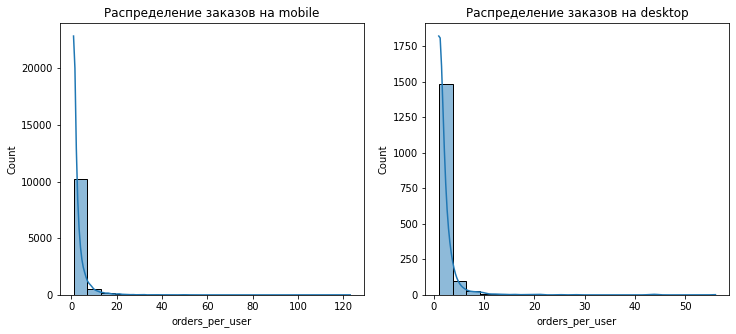

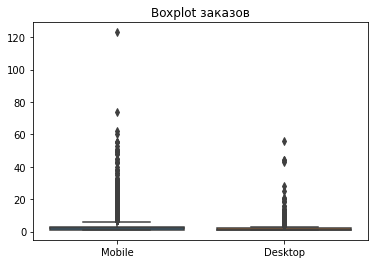

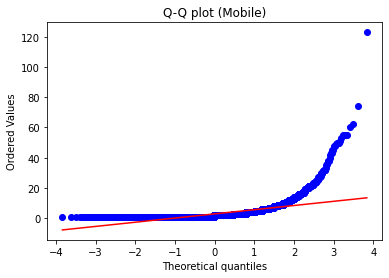

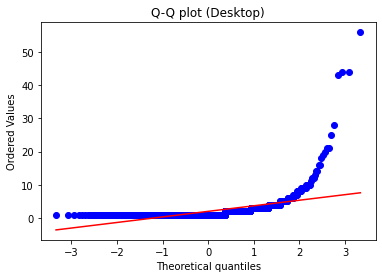

In [70]:
# Гистограммы
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(mobile_orders, bins=20, kde=True)
plt.title("Распределение заказов на mobile")

plt.subplot(1,2,2)
sns.histplot(desktop_orders, bins=20, kde=True)
plt.title("Распределение заказов на desktop")
plt.show()

# Boxplot
sns.boxplot(data=[mobile_orders, desktop_orders])
plt.xticks([0,1], ["Mobile", "Desktop"])
plt.title("Boxplot заказов")
plt.show()

# Q-Q графики
stats.probplot(mobile_orders, dist="norm", plot=plt)
plt.title("Q-Q plot (Mobile)")
plt.show()

stats.probplot(desktop_orders, dist="norm", plot=plt)
plt.title("Q-Q plot (Desktop)")
plt.show()

In [71]:
print("Shapiro-Wilk (Mobile):", shapiro(mobile_orders))
print("Shapiro-Wilk (Desktop):", shapiro(desktop_orders))

Shapiro-Wilk (Mobile): ShapiroResult(statistic=0.45469969511032104, pvalue=0.0)
Shapiro-Wilk (Desktop): ShapiroResult(statistic=0.30236363410949707, pvalue=0.0)


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапиро–Уилка (W)

W очень маленькие (0.45 и 0.3), что указывает на сильное отклонение от нормального распределения.

p-value = 0, что означает, что нулевая гипотеза о нормальности отвергается с очень высокой вероятностью.

**Выбор статистического теста**

Данные о количестве заказов не нормированы и дискретны, поэтому логично использовать непараметрический тест Манна–Уитни (Mann–Whitney U).

**Гипотеза 2: Среднее время между заказами (days_since_prev)**

Нулевая гипотеза H0: Среднее время между заказами одинаково для пользователей мобильных и стационарных устройств.

Альтернативная гипотеза H1: Среднее время между заказами выше для мобильных пользователей.

In [72]:
# Берем только записи с ненулевыми значениями days_since_prev
autumn_intervals = autumn_orders.dropna(subset=["days_since_prev"])

mobile_intervals = autumn_intervals[autumn_intervals["device_type_canonical"] == "mobile"]["days_since_prev"]
desktop_intervals = autumn_intervals[autumn_intervals["device_type_canonical"] == "desktop"]["days_since_prev"]

**Выбор статистического теста**

Данные о днях между заказами часто имеют скачкообразное распределение и выбросы, поэтому лучше Mann–Whitney U.

In [73]:
# Гипотеза 1: количество заказов
stat_orders, p_orders = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

# Гипотеза 2: время между заказами
stat_intervals, p_intervals = mannwhitneyu(mobile_intervals, desktop_intervals, alternative='greater')

print(f"Orders per user: U={stat_orders}, p={p_orders}")
print(f"Days between orders: U={stat_intervals}, p={p_intervals}")

Orders per user: U=10630578.0, p=5.5459811039692874e-40
Days between orders: U=2264507795.0, p=6.434064205798213e-93


Количество заказов на одного пользователя (Orders per user): p-value ≈ 5.55е-40, что значительно меньше уровня значимости 0.05. Это позволяет отвергнуть нулевую гипотезу. Следовательно, пользователи мобильных устройств действительно совершают в среднем больше заказов по сравнению с пользователями стационарных устройств.

Время между заказами (Days between orders): p-value ≈ 6.43e-93, также существенно меньше 0.05. Это подтверждает, что нулевая гипотеза отвергается, и среднее время между заказами у мобильных пользователей выше, чем у пользователей стационарных устройств.

**Вывод:** мобильные пользователи проявляют более высокую активность с точки зрения количества заказов, но делают их с более длительными интервалами. Это может указывать на более плановую и целенаправленную активность через мобильное приложение, в то время как стационарные пользователи совершают заказы чаще, но в меньших объёмах.

## Общий вывод и рекомендации

В проекте был использован объединённый и очищенный набор данных, включающий заказы билетов (final_tickets_orders_df.csv), события (final_tickets_events_df.csv) и курс тенге к рублю (final_tickets_tenge_df.csv). Данные охватывают период 2024 года, с детализацией по устройствам пользователей, регионам, партнёрам, типам мероприятий и выручке. Проведена предобработка: проверка на дубликаты, обработка пропусков, корректировка типов данных, фильтрация выбросов и конвертация валюты.

**Основные результаты анализа:**

Сезонные изменения: с июня по октябрь наблюдается рост числа заказов, с пиком осенью. Летом преобладают заказы с мобильных устройств, осенью доля стационарных устройств увеличивается. Средняя стоимость билета (one_ticket_revenue_rub) по типам мероприятий меняется осенью — для выставок и стендапа растёт, для других категорий стабильна или снижается.

Популярные события и партнёры: Каменевский регион и Североярская область формируют почти половину всех заказов и мероприятий. Среди партнёров лидируют «Билеты без проблем», «Лови билет!» и «Мой билет» по выручке и числу заказов; «Мой билет» имеет более высокий средний чек.

Возрастные категории: взрослые мероприятия (16+, 18+) становятся более популярными в летний период, а доля заказов на детские мероприятия остаётся стабильной.

Активность пользователей: среднее число заказов на одного пользователя выше у мобильных пользователей, но при этом время между заказами также больше. Это указывает на более плановую активность мобильных пользователей и более частые, но меньшие по объёму заказы у стационарных пользователей.

**Результаты проверки гипотез:**

Количество заказов на пользователя: гипотеза о большем среднем количестве заказов у мобильных пользователей подтверждена (p ≈ 5.55е-40).

Время между заказами: гипотеза о большем среднем интервале между заказами у мобильных пользователей также подтверждена (p ≈ 6.43e-93).

**Рекомендации:**

Активнее таргетировать пользователей мобильных устройств с промо-акциями на новые мероприятия, учитывая их склонность к большим, но редким заказам.

В регионах-лидерах (Каменевский регион и Североярская область) стоит расширять ассортимент мероприятий и усиливать маркетинг.

Партнёрам с высоким средним чеком, например «Мой билет», можно предлагать премиальные билеты или мероприятия с высокой ценой для максимизации выручки.

Учитывать сезонные колебания: осенью акцент на популярные категории мероприятий, повышающие средний чек (выставки, стендап), летом — мероприятия для молодёжи и детей.

Следить за недельной цикличностью: будние дни генерируют больше заказов, что можно учитывать при планировании маркетинговых кампаний.